# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

### Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Part 0: Building the network 

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.


    In our study focused on the network of rappers, we employed a two-step methodology for hyperlink analysis on individual rapper webpages. First, we made use of regular expressions to extract all outgoing links from webpages that were pre-downloaded. This allowed us to compile a list of links that served as nodes within the rapper network.

    Second, to ensure that these outgoing links were indeed relevant to our network study, we cross-referenced the extracted URLs with the CSV file containing known rappers. Thus enabling us to eliminate any links that did not point to a rapper within our defined network.

> * Show the regular expressions you have built and explain in details how they work.

In [1]:
pattern = r'\[\[(?:Category:)?([^\|\]]+)(?:\|[^\]]+)?\]\]'

    Finds matches that start with "[[" and end with "]]".
    Optionally looks for "Category:".
    Captures text not including "|" or "]".
    Optionally considers a "|" followed by text not including "]".
    For example, it captures "Rapper" from the string [[Category:Rapper|Some text]].



## Building the networks

In [2]:

import pandas as pd 
import re
import requests

EastCoast=pd.read_csv('/Users/danielhoang/Documents/GitHub/socialgraphs2019/files/EastCoastRappers.csv')
WestCoast=pd.read_csv('/Users/danielhoang/Documents/GitHub/socialgraphs2019/files/WestCoastRappers.csv')
TopRapper = EastCoast.WikipediaPageName[0]
TopRapper = EastCoast.WikipediaPageName[0]
TopRapper

# remove parentheses content from a string
def remove_parentheses_content(s):
    return re.sub(r'\(.*?\)', '', s).strip()

# Get links from wikipedia
def get_links_from_wikipedia(rapper_name):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": rapper_name
    }
    wikitext_request = requests.get(baseurl, params=params)
    wikijson = wikitext_request.json()

    page_id = list(wikijson["query"]["pages"].keys())[0]
    wikitext = wikijson["query"]["pages"][page_id]["revisions"][0]["*"]

    pattern = r'\[\[(?:Category:)?([^\|\]]+)(?:\|[^\]]+)?\]\]'
    matched_links = re.findall(pattern, wikitext)
    
    return matched_links

# Read in the data
EastCoast = pd.read_csv('/Users/danielhoang/Documents/GitHub/socialgraphs2019/files/EastCoastRappers.csv')
WestCoast = pd.read_csv('/Users/danielhoang/Documents/GitHub/socialgraphs2019/files/WestCoastRappers.csv')

# Get links for each rapper
eastcoast_links = {rapper: get_links_from_wikipedia(rapper) for rapper in EastCoast.WikipediaPageName}
westcoast_links = {rapper: get_links_from_wikipedia(rapper) for rapper in WestCoast.WikipediaPageName}

# Remove parentheses content from links
eastcoast_links = {rapper: [remove_parentheses_content(link) for link in links] for rapper, links in eastcoast_links.items()}
westcoast_links = {rapper: [remove_parentheses_content(link) for link in links] for rapper, links in westcoast_links.items()}


print(eastcoast_links)
print(westcoast_links)

{'6ix9ine': ['New York City', 'Hip hop music', 'scream rap', 'hardcore hip hop', 'SoundCloud rap', 'punk rap', 'Apple Music', 'Create Music Group', '10K Projects', 'Virgin Music Label & Artist Services', 'Shotti', 'feud', 'Poles 1469', 'Gummo', 'sleeper hit', 'mixtape', 'Day69', 'Kooda', 'Keke', 'Fetty Wap', 'A Boogie wit da Hoodie', 'Gotti', 'Billboard Hot 100', 'Fefe', 'Nicki Minaj', 'Murda Beatz', 'Dummy Boy', 'Billboard 200', 'RIAA certification', 'Recording Industry Association of America', 'pleaded guilty', 'felony', 'Child pornography', 'probation', 'Trial of the Nine Trey Gangsters', 'Racket', 'Conspiracy', 'Murder', 'armed robbery', 'COVID-19 pandemic', 'COVID-19', 'asthma', 'Gooba', 'Trollz', 'TattleTales', 'Billboard 200', 'Leyenda Viva', 'reggaeton', 'informant', 'Trial of the Nine Trey Gangsters', 'Bushwick, Brooklyn', 'Brooklyn', 'Atlixco', 'Puebla', 'Río Piedras, Puerto Rico', 'San Juan, Puerto Rico', 'Tidal', 'Psalm 121', 'Child School and Legacy High School', 'Emotiona

In [3]:
import networkx as nx
#For each link check if it matches from the csv file. That must mean it indeed is a rapper, if not remove it from the list
all_rappers=list(EastCoast.WikipediaPageName)+list(WestCoast.WikipediaPageName)

def filter_links_based_on_csv(rapper_links):
    return [link for link in rapper_links if link in all_rappers]

filtered_eastcoast_links = {rapper: filter_links_based_on_csv(links) for rapper, links in eastcoast_links.items()}
filtered_westcoast_links = {rapper: filter_links_based_on_csv(links) for rapper, links in westcoast_links.items()}

filtered_eastcoast_links 

#Store rappers as nodes in networkX graph 

G = nx.DiGraph()
G.add_nodes_from(all_rappers)

#Add directed edges between rappers that are linked to each other
for rapper, links in filtered_eastcoast_links.items():
    for link in links:
        G.add_edge(rapper, link)

for rapper, links in filtered_westcoast_links.items():
    for link in links:
        G.add_edge(rapper, link)

#Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))# Store rappers as nodes in networkX directed graph

G = nx.DiGraph()  # Use DiGraph for directed graph
G.add_nodes_from(all_rappers)

# Add directed edges between rappers that are linked to each other
for rapper, links in filtered_eastcoast_links.items():
    for link in links:
        G.add_edge(rapper, link)

for rapper, links in filtered_westcoast_links.items():
    for link in links:
        G.add_edge(rapper, link)

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

# Print the top nodes with the highest in-degree and out-degree
top_in_degree = sorted(dict(G.in_degree()).items(), key=lambda x: x[1], reverse=True)[:5]
top_out_degree = sorted(dict(G.out_degree()).items(), key=lambda x: x[1], reverse=True)[:5]



# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 


In [4]:


print("Number of nodes:", G.number_of_nodes())


Number of nodes: 723


> * What is the number of links?


In [5]:
print("Number of edges:", G.number_of_edges())


Number of edges: 5275


> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?


In [6]:
print("Highest in-degree:", top_in_degree[0])
print("Highest out-degree:", top_out_degree[0])


Highest in-degree: ('Snoop Dogg', 126)
Highest out-degree: ('Drag-On', 43)


'Snoop Dogg' has the highest in-degree of 126, indicating he is a highly influential node, which aligns with his public profile. 'Drag-On' has the highest out-degree of 43, suggesting he is very active in making connections. The findings are generally consistent with what might be expected, especially for a figure like Snoop Dogg.



> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 


In [7]:
top_5_east = sorted(dict(G.in_degree()).items(), key=lambda x: x[1], reverse=True)[:5]
print('top 5 east', top_5_east)

top 5 east [('Snoop Dogg', 126), ('Jay-Z', 116), ('Nas', 104), ('50 Cent', 93), ('Busta Rhymes', 83)]


> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?


In [8]:
top_5_west = sorted(dict(G.in_degree()).items(), key=lambda x: x[1], reverse=True)[:5]
print('top 5 west', top_5_west)

top 5 west [('Snoop Dogg', 126), ('Jay-Z', 116), ('Nas', 104), ('50 Cent', 93), ('Busta Rhymes', 83)]


> * Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.


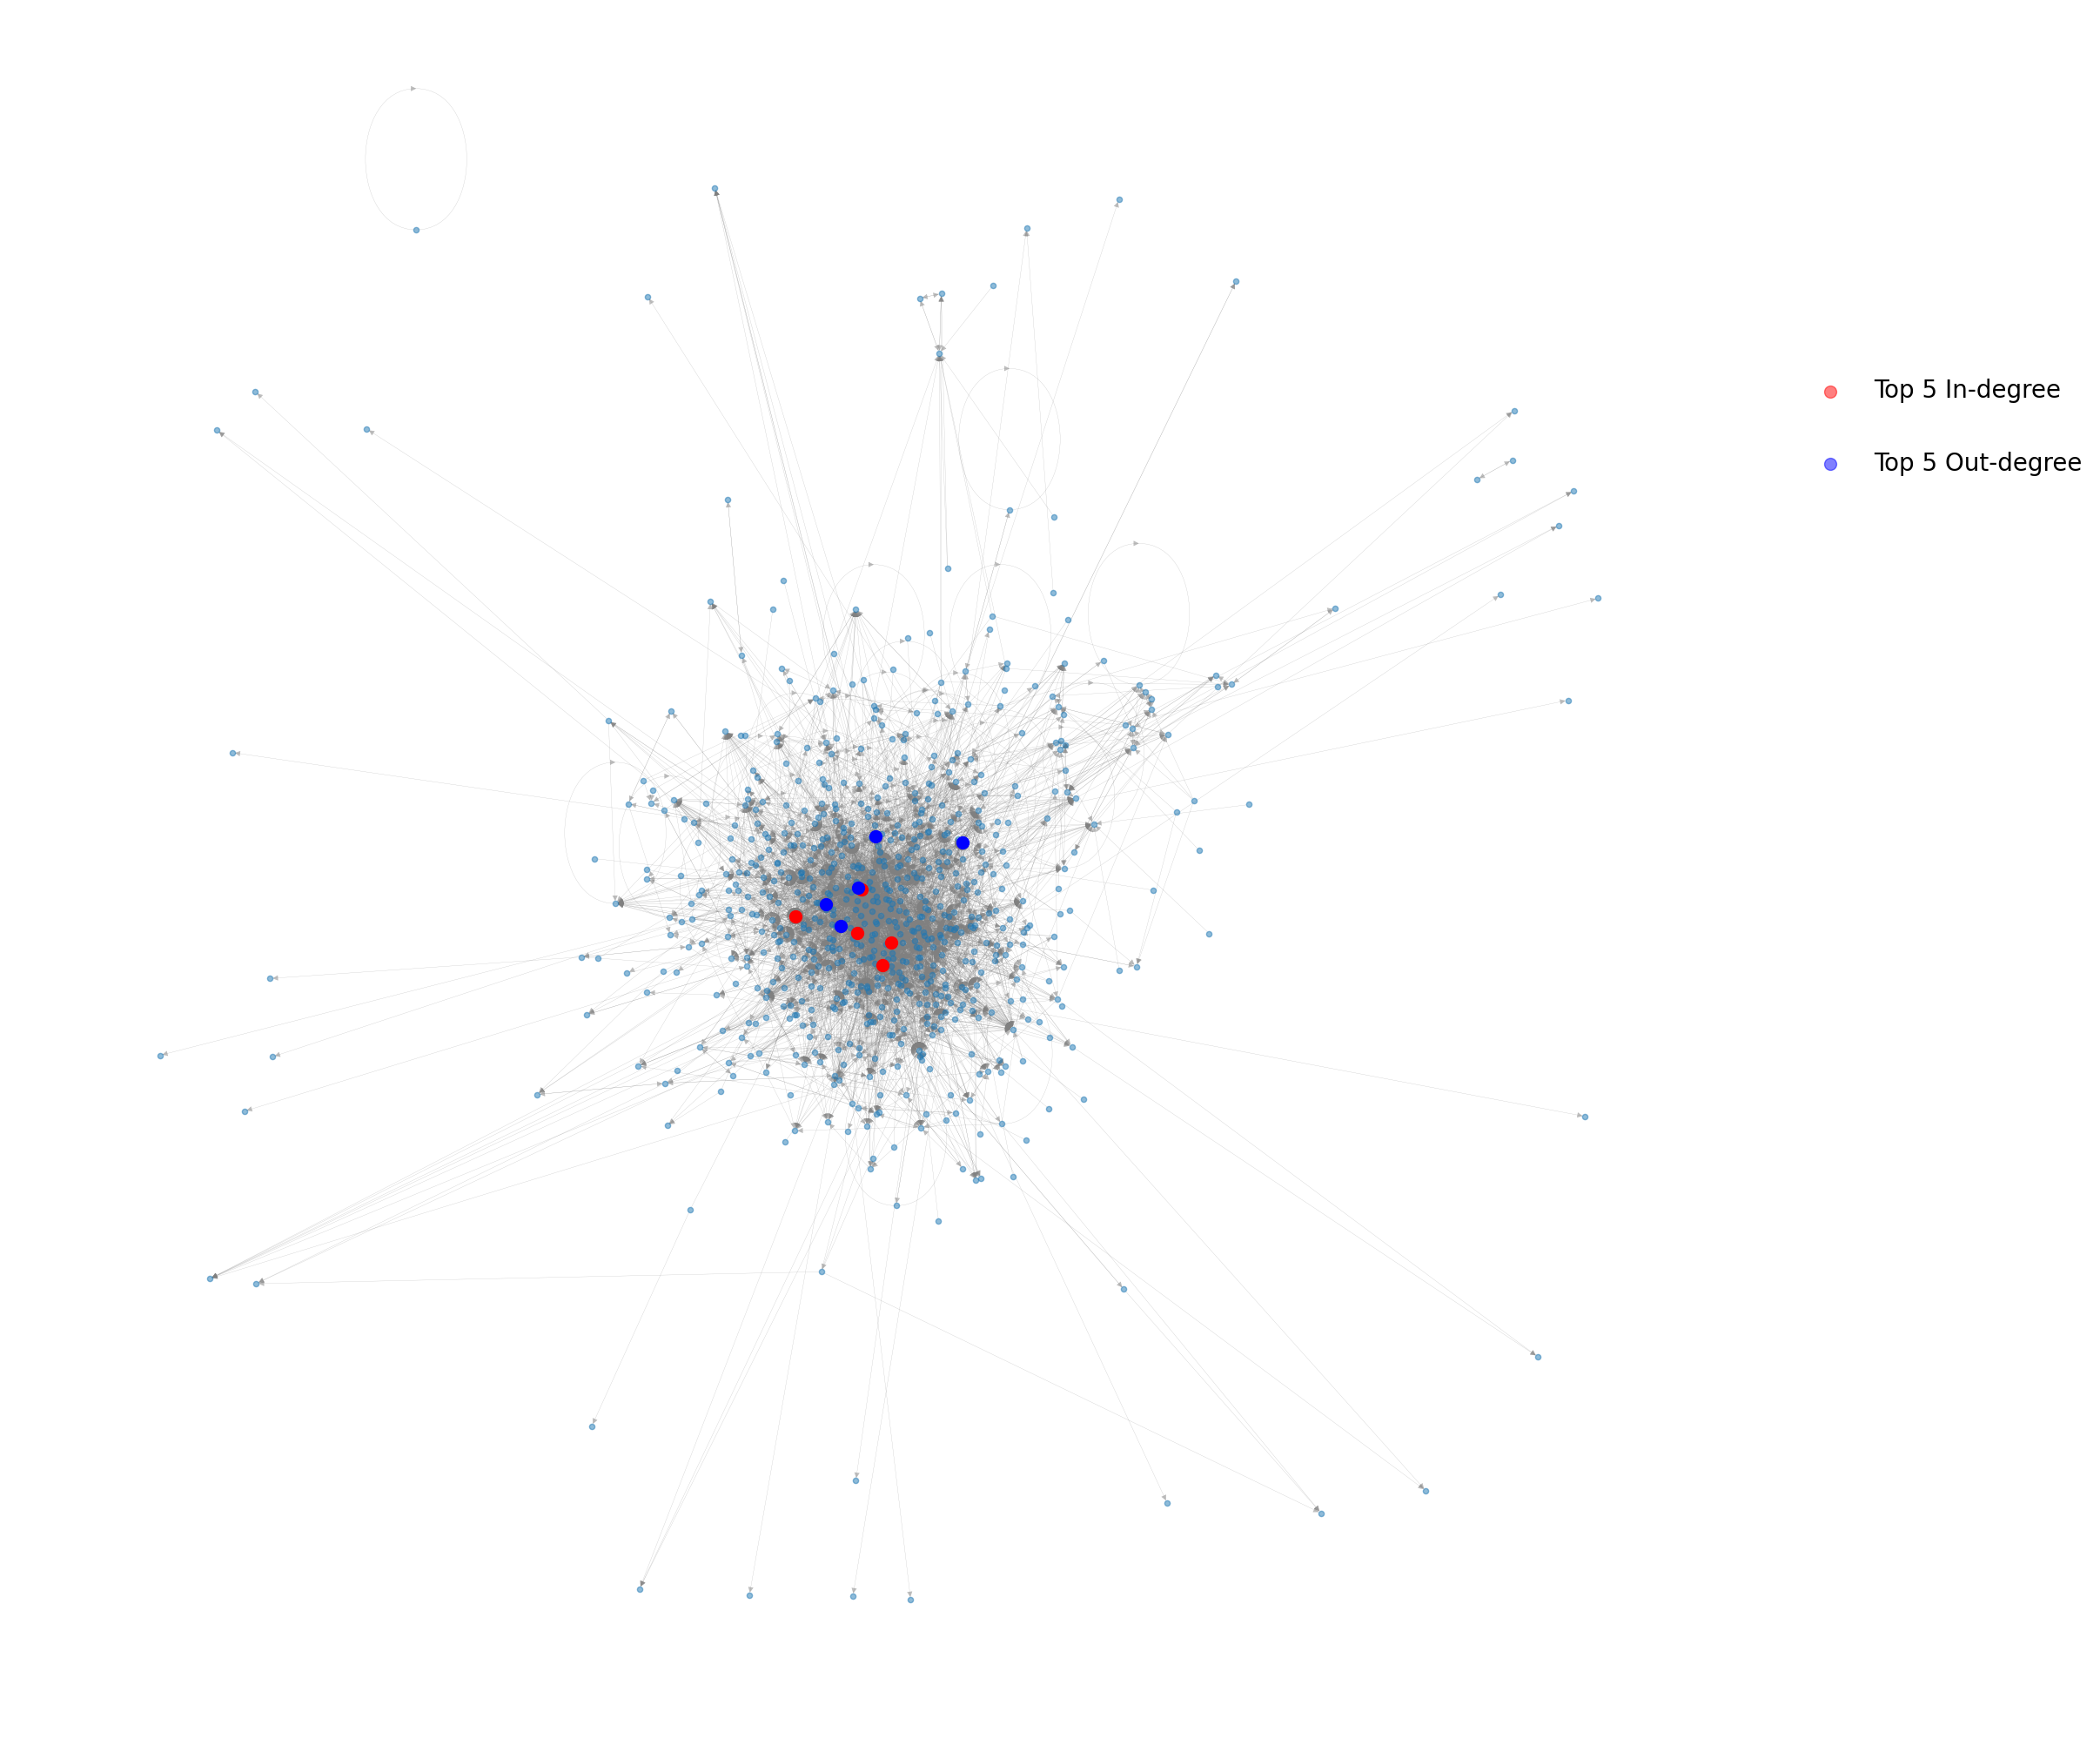

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# plot the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.05, iterations=20)
nx.draw(G, pos, node_size=20, edge_color='grey', width=0.2, with_labels=False, alpha=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=[node for node, degree in top_in_degree], node_size=100, node_color='red')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node, degree in top_out_degree], node_size=100, node_color='blue')

# legend for the top nodes
plt.scatter([], [], c='red', alpha=0.5, s=100, label='Top 5 In-degree')
plt.scatter([], [], c='blue', alpha=0.5, s=100, label='Top 5 Out-degree')
plt.legend(scatterpoints=1, frameon=False, labelspacing=2, bbox_to_anchor=(1.02, 0.8), loc='upper left', fontsize=20)
plt.show()


>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?


> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?


In [10]:
import powerlaw  # make sure to install this package first

# Extract in-degree and out-degree sequences from the graph
in_degrees = [deg for node, deg in G.in_degree()]
out_degrees = [deg for node, deg in G.out_degree()]

# Fit the in-degree and out-degree distributions and find alpha
fit_in = powerlaw.Fit(in_degrees, discrete=True)
fit_out = powerlaw.Fit(out_degrees, discrete=True)

# Extract the exponents
alpha_in = fit_in.alpha
alpha_out = fit_out.alpha

print(f"The exponent (alpha) of the in-degree distribution is {alpha_in}")
print(f"The exponent (alpha) of the out-degree distribution is {alpha_out}")


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
The exponent (alpha) of the in-degree distribution is 3.3242040223213363
The exponent (alpha) of the out-degree distribution is 3.78072904717168


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.



_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.


> * Describe the structure you observe. What useful information can you decipher from this?

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.


In [11]:
import zipfile
import os
from collections import Counter
import string

def tokenize_and_count(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    return Counter(tokens)

def count_total_words(files, dir_path):
    word_count = Counter()
    for filename in files:
        rapper_name = '.'.join(filename.split('.')[:-1]).replace('_', ' ').lower()
        file_path = os.path.join(dir_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                tokens = tokenize_and_count(text)
                word_count[rapper_name] = sum(tokens.values())
        except Exception as e:
            print(f"An error occurred while processing {file_path}: {e}")
    return word_count

def is_text_file(filename):
    return filename.endswith('.txt') and os.path.isfile(filename)

def process_zip_and_count_words(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    subfolder_name = os.path.basename(zip_path).split('.zip')[0]
    subfolder_path = os.path.join(extract_path, subfolder_name)
    files = [f for f in os.listdir(subfolder_path) if is_text_file(os.path.join(subfolder_path, f))]
    return count_total_words(files, subfolder_path)

if __name__ == "__main__":
    directory_path = '/Users/danielhoang/Documents/GitHub/socialgraphs2019/lectures/week7_rapper_zip'  

    eastcoast_word_count = process_zip_and_count_words(f'{directory_path}/eastcoasttexts.zip', f'{directory_path}/eastcoasttexts')
    print("East Coast Top 10:", eastcoast_word_count.most_common(10))

    westcoast_word_count = process_zip_and_count_words(f'{directory_path}/westcoasttexts.zip', f'{directory_path}/westcoasttexts')
    print("West Coast Top 10:", westcoast_word_count.most_common(10))
    


East Coast Top 10: [('john cena', 12387), ("shaquille o'neal", 11869), ('50 cent', 9542), ('cardi b', 8731), ("lil' kim", 8533), ('jay-z', 8067), ('nas', 7392), ('dmx', 7090), ('lil peep', 6206), ('french montana', 6080)]
West Coast Top 10: [('dr. dre', 10805), ('kendrick lamar', 9385), ('snoop dogg', 9294), ('tupac shakur', 8190), ('the game (rapper)', 6731), ('jay park', 6689), ('becky g', 5888), ('ice-t', 5349), ('tyler, the creator', 4677), ('lecrae', 4389)]


In [12]:
import zipfile
import os
from collections import Counter
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# Download NLTK data
nltk.download('wordnet')
nltk.download('stopwords')

# Instantiate WordNetLemmatizer and set English stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define clean_and_tokenize method that lowercases text, removes punctuation, tokenizes text, lemmatizes text, and removes stop words
def clean_and_tokenize(text):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Define create_tf_list method that takes a list of files and directory path, and returns a Counter object of word frequencies
def create_tf_list(files, dir_path):
    tf_list = Counter()
    for filename in files:
        file_path = os.path.join(dir_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            tokens = clean_and_tokenize(text)
            tf_list.update(tokens)
    return tf_list

# Define process_zip_and_count_words method that takes a zip file path and extraction path, and returns a Counter object of word frequencies
def process_zip_and_count_words(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    subfolder_name = os.path.basename(zip_path).split('.zip')[0]
    subfolder_path = os.path.join(extract_path, subfolder_name)
    files = [f for f in os.listdir(subfolder_path) if is_text_file(os.path.join(subfolder_path, f))]
    return create_tf_list(files, subfolder_path)

# Define directory path
directory_path = '/Users/danielhoang/Documents/GitHub/socialgraphs2019/lectures/week7_rapper_zip'

# Call process_zip_and_count_words method on East Coast zip file to get Counter object of word frequencies
eastcoast_tf_list = process_zip_and_count_words(f'{directory_path}/eastcoasttexts.zip', f'{directory_path}/eastcoasttexts')
print("East Coast TF List:", eastcoast_tf_list.most_common(10))

# Call process_zip_and_count_words method on West Coast zip file to get Counter object of word frequencies
westcoast_tf_list = process_zip_and_count_words(f'{directory_path}/westcoasttexts.zip', f'{directory_path}/westcoasttexts')
print("West Coast TF List:", westcoast_tf_list.most_common(10))

ModuleNotFoundError: No module named 'nltk'

In [13]:
import math

def create_word_cloud_string(tf_tr_list):
    words = []
    for word, score in tf_tr_list.items():
        rounded_score = math.ceil(score)
        repeated_words = [word] * rounded_score
        words.extend(repeated_words)
    return ' '.join(words)

westcoast_word_cloud_str = create_word_cloud_string(westcoast_tf_tr)
eastcoast_word_cloud_str = create_word_cloud_string(eastcoast_tf_tr)

NameError: name 'westcoast_tf_tr' is not defined

In [ ]:
import wordcloud 
import matplotlib.pyplot as plt

def create_word_cloud(text):
    wc = wordcloud.WordCloud().generate(text)  
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

create_word_cloud(westcoast_word_cloud_str)
create_word_cloud(eastcoast_word_cloud_str)


> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [ ]:
# Find 5 highest TR score for each coast
top_5_west = westcoast_tf_tr.most_common(5)
top_5_east = eastcoast_tf_tr.most_common(5)

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 


    To which degree communities can be divided into smaller tight-knit communities. In other words friends within a larger friendgroup.

> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?


> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.


>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.


> * Now, partition your rappers into two communities based on which coast they represent.


In [ ]:
# Label node according to coast attribute
import networkx as nx

# convert the graph to undirected
G_undirected = G.to_undirected()

east_community = []
west_community = []

# Assign community labels
for node in east_community:
    G_undirected.nodes[node]['coast'] = 'East'
for node in west_community:
    G_undirected.nodes[node]['coast'] = 'West'


for node, attrs in G_undirected.nodes(data=True):
    print(f"Node {node} belongs to {attrs['coast']}")


# Populate the community lists based on the 'coast' attribute
east_community = [node for node, attrs in G_undirected.nodes(data=True) if attrs['coast'] == 'East']
west_community = [node for node, attrs in G_undirected.nodes(data=True) if attrs['coast'] == 'West']

print("East community size:", len(east_community))
print("West community size:", len(west_community))


In [ ]:
import community
from collections import Counter
import matplotlib.pyplot as plt


G_east = G_undirected.subgraph(east_community)
G_west = G_undirected.subgraph(west_community)

partition_east = community.best_partition(G_east)
partition_west = community.best_partition(G_west)

# Count the number of nodes in each coast
community_count_east = Counter(partition_east.values())
community_count_west = Counter(partition_west.values())

# Layout
pos_east = nx.spring_layout(G_east, seed=42)
pos_west = nx.spring_layout(G_west, seed=42)

# Initialize the plot
plt.figure(figsize=(24, 10))

# Draw East Coast graph
plt.subplot(1, 2, 1)
nx.draw(G_east, pos_east, with_labels=False, node_color=list(partition_east.values()),
        node_size=700, cmap=plt.cm.rainbow, vmin=0, vmax=max(partition_east.values()))
plt.title("East Coast Rapper Communities", fontsize=20)

# Draw West Coast graph
plt.subplot(1, 2, 2)
nx.draw(G_west, pos_west, with_labels=False, node_color=list(partition_west.values()),
        node_size=700, cmap=plt.cm.rainbow, vmin=0, vmax=max(partition_west.values()))
plt.title("West Coast Rapper Communities", fontsize=20)

plt.show()




>   * What is the modularity of this partition? Comment on the result.

In [ ]:
# community modularity
modularity_east = community.modularity(partition_east, G_east)
modularity_west = community.modularity(partition_west, G_west)

print(f"East Coast modularity: {modularity_east}")
print(f"West Coast modularity: {modularity_west}")


    It is much higher than what we found for coasts as communities. The low modularity score when dividing rappers by coast suggests that the East and West Coasts aren't distinct communities within the overall network, possibly due to frequent collaborations or similar styles. However, within each coast, the community structures differ: the East Coast shows a high modularity score, indicating well-defined tight-knit sub-groups with fewer inter-group collaborations. In contrast, the West Coast has a moderate score, suggesting a collaborative environment where artists frequently work across community boundaries.

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

**Congratulations for making it to the end of the Assignment. Good luck with your independent project**

